<a href="https://colab.research.google.com/github/evabrixy/PROJET_DDEFI_2025/blob/main/MidTerm_BRIXY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price         Adj Close        Close         High          Low         Open  \
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC        ^GSPC   
Date                                                                          
2018-01-02  2695.810059  2695.810059  2695.889893  2682.360107  2683.729980   
2018-01-03  2713.060059  2713.060059  2714.370117  2697.770020  2697.850098   
2018-01-04  2723.989990  2723.989990  2729.290039  2719.070068  2719.310059   
2018-01-05  2743.149902  2743.149902  2743.449951  2727.919922  2731.330078   
2018-01-08  2747.709961  2747.709961  2748.510010  2737.600098  2742.669922   

Price           Volume  
Ticker           ^GSPC  
Date                    
2018-01-02  3397430000  
2018-01-03  3544030000  
2018-01-04  3697340000  
2018-01-05  3239280000  
2018-01-08  3246160000  
Price      Adj Close Close   High   Low   Open Volume
Ticker          ^VIX  ^VIX   ^VIX  ^VIX   ^VIX   ^VIX
Date                                                 
2018-

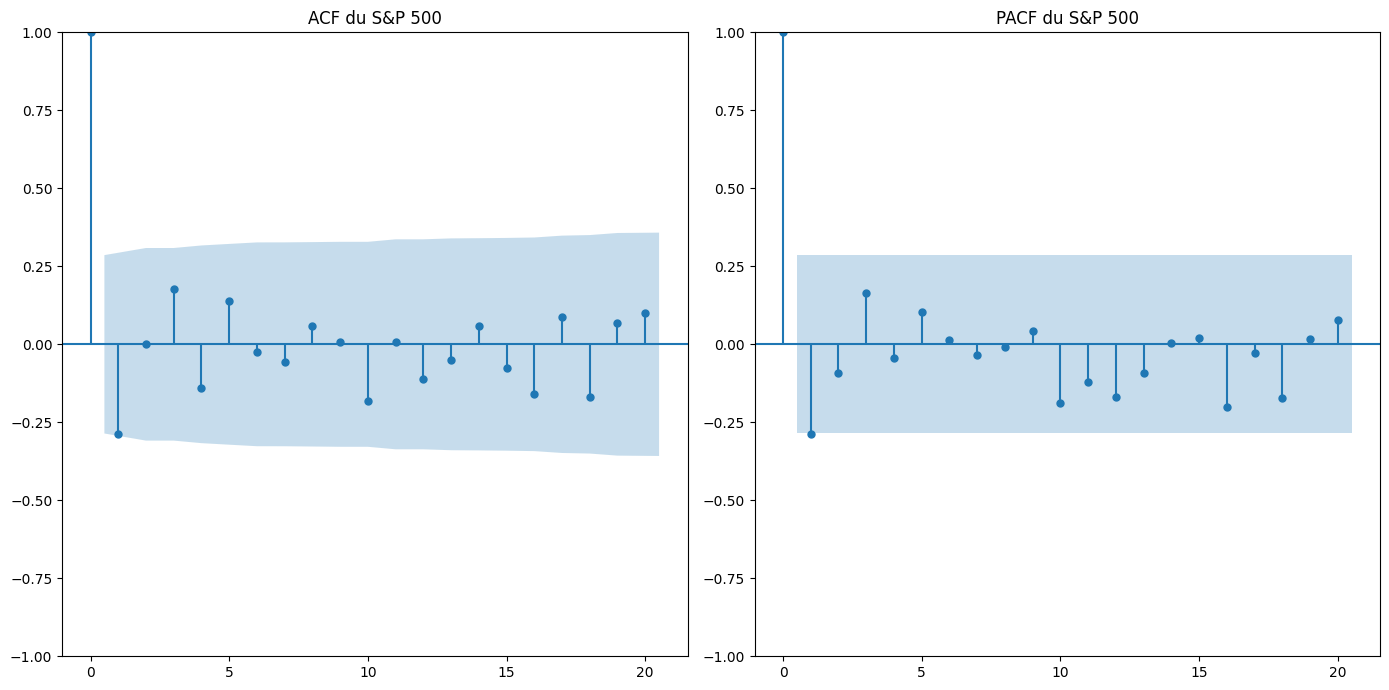

Linear Regression MAE: 0.026504687437047363
Linear Regression RMSE: 0.03133872835965377
Random Forest MAE: 0.035894849853587436
Random Forest RMSE: 0.038641967118463655


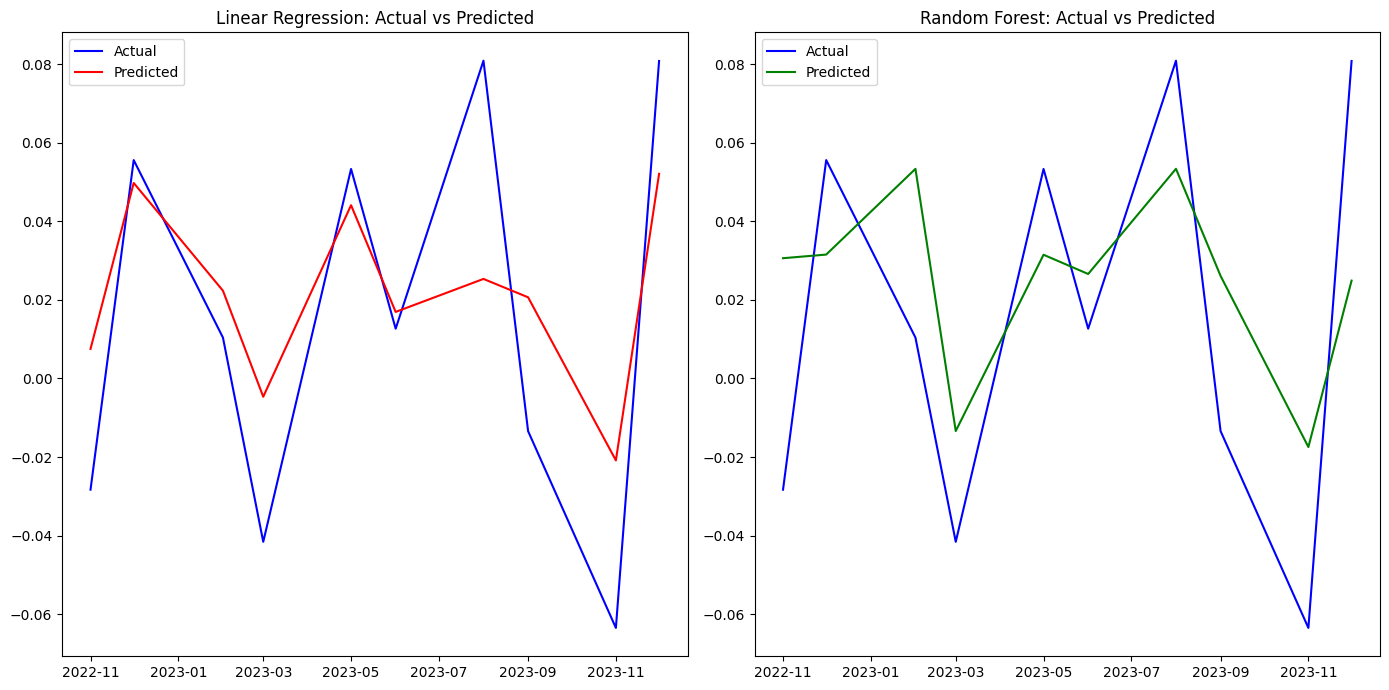

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
!pip install yfinance pandas_datareader scikit-learn matplotlib
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Récupérer les données
sp500_data = yf.download('^GSPC', start='2018-01-01', end='2023-12-31')
vix_data = yf.download('^VIX', start='2018-01-01', end='2023-12-31')
interest_rate_data = yf.download('^IRX', start='2018-01-01', end='2023-12-31')
cpi_data = web.DataReader('CPIAUCSL', 'fred', start='2018-01-01', end='2023-12-31')

print(sp500_data.head())
print(vix_data.head())
print(interest_rate_data.head())
print(cpi_data.head())

# Fusionner les données
merged_data = pd.concat([sp500_data['Close'], vix_data['Close'], interest_rate_data['Close'], cpi_data], axis=1)
merged_data.columns = ['SP500_Close', 'VIX_Close', 'Interest_Rate', 'CPI_Close']

print(merged_data.head())

# Enlever les valeurs manquantes
merged_data.dropna(inplace=True)

# Calcul des log return
merged_data['SP500_Log_Return'] = np.log(merged_data['SP500_Close'] / merged_data['SP500_Close'].shift(1))
merged_data['VIX_Log_Return'] = np.log(merged_data['VIX_Close'] / merged_data['VIX_Close'].shift(1))
merged_data['Interest_Rate_Log_Return'] = np.log(merged_data['Interest_Rate'] / merged_data['Interest_Rate'].shift(1))
merged_data['CPI_Log_Return'] = np.log(merged_data['CPI_Close'] / merged_data['CPI_Close'].shift(1))
merged_data.dropna(inplace=True)

print(merged_data.head())

# Séparer variables exogènes et rendements du S&P 500
X = merged_data[['VIX_Log_Return', 'Interest_Rate_Log_Return', 'CPI_Log_Return']]
y = merged_data['SP500_Log_Return']

# Test ADF
def adf_test(series, series_name):
    result = adfuller(series)
    print(f"Test ADF pour {series_name}:")
    print(f"Statistique ADF: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Hypothèse nulle: La série a une racine unitaire (non stationnaire)")
    print("Conclusion: La série est stationnaire si p-value < 0.05\n")

adf_test(merged_data['SP500_Log_Return'], 'S&P 500')
adf_test(merged_data['VIX_Log_Return'], 'VIX')
adf_test(merged_data['Interest_Rate_Log_Return'], 'Taux d\'intérêt')
adf_test(merged_data['CPI_Log_Return'], 'CPI')

# ACF et PACF
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plot_acf(merged_data['SP500_Log_Return'], lags=20, ax=plt.gca())  # Lags réduit à 20
plt.title('ACF du S&P 500')
plt.subplot(1, 2, 2)
plot_pacf(merged_data['SP500_Log_Return'], lags=20, ax=plt.gca())  # Lags réduit à 20
plt.title('PACF du S&P 500')
plt.tight_layout()
plt.show()

# Séparation des données en 80% d'entraînement et 20% de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modèle de régression linéaire
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Erreurs
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print(f"Linear Regression MAE: {lr_mae}")
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest RMSE: {rf_rmse}")

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, lr_predictions, label='Predicted', color='red')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, rf_predictions, label='Predicted', color='green')
plt.title('Random Forest: Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.savefig('/content/predictions_comparison.png')
plt.show()
from google.colab import files
files.download('/content/predictions_comparison.png')
